Решать будем задачу с Kaggle про предсказание длины поездки в такси [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

Первым делом необходимо скачать данные. Воспользуйтесь следующей инструкцией: [Как скачать данные с kaggle в colab.](https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8) Ниже есть необходимый код, вам нужно лишь запрость токен на kaggle и загрузить его.

In [622]:
# !pip install -q kaggle

In [623]:
# from google.colab import files
# uploaded = files.upload()

In [624]:
# !mkdir /root/.kaggle
# !mv kaggle.json /root/.kaggle/kaggle.json
# !kaggle competitions download -c nyc-taxi-trip-duration
# !unzip "/content/nyc-taxi-trip-duration.zip" -d "/content"

In [625]:
# import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [626]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [627]:
df = df.drop(['dropoff_datetime', 'store_and_fwd_flag', 'id'], axis=1)

In [628]:
import datetime as dt
df.pickup_datetime = pd.to_datetime(df.pickup_datetime).map(dt.datetime.toordinal)

In [629]:
df = df.sort_values(by='pickup_datetime')

In [630]:
df.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
333752,1,735964,1,-73.963486,40.768528,-73.969521,40.757580,274
616306,1,735964,1,-73.998032,40.751167,-73.976761,40.751854,455
1391034,1,735964,1,-74.005302,40.728542,-73.978622,40.764221,1070
1138825,2,735964,1,-73.977592,40.632847,-73.977592,40.632847,413
537651,2,735964,2,-73.956978,40.770802,-73.979050,40.785332,540


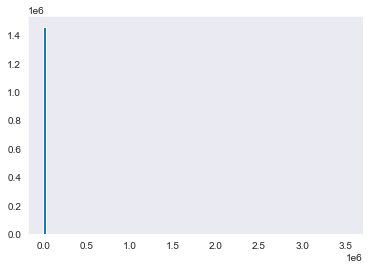

In [631]:
df.trip_duration.hist(bins=100, grid=False, )
plt.show()

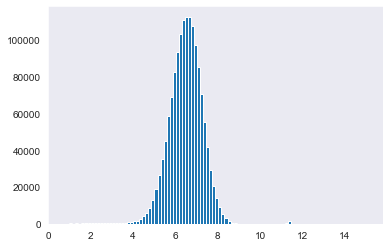

In [632]:
np.log1p(df.trip_duration).hist(bins=100, grid=False)
plt.show()

Построить линейную регрессию зависимости trip_duration от других переменных двумя способами

In [633]:
from math import radians, sin, cos, sqrt, atan2
def haversine(row):
    # Approximate radius of Earth in km
    R = 6371.0

    lat1 = radians(row['pickup_latitude'])
    lon1 = radians(row['pickup_longitude'])
    lat2 = radians(row['dropoff_latitude'])
    lon2 = radians(row['dropoff_longitude'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance * 1000

df['distance'] = df.apply(haversine, axis=1)
Y = df['trip_duration'].to_numpy()
X = df.drop(columns='trip_duration')

In [634]:
# With statsmodel
import statsmodels.api as sm
lm = sm.OLS.from_formula('trip_duration ~ distance + vendor_id + dropoff_latitude + dropoff_longitude + pickup_latitude + pickup_longitude + passenger_count + pickup_datetime + vendor_id', df)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1751.
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:19:44   Log-Likelihood:            -1.4554e+07
No. Observations:             1458644   AIC:                         2.911e+07
Df Residuals:                 1458635   BIC:                         2.911e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -2.88e+05   6.22e+04     -4.631      0.000    -4.1e+05   -1.66e+05
distance              0.1117      0.001    103.922      0.000       0.110       0.114
vendor_id           199.9185      9.035     22.127      0.000     182.210     217.627
dropoff_latitude   -596.9809    139.449     -4.281      0.000    -870.297    -323.665
dropoff_longitude   256.0813     99.922      2.563      0.010      60.238     451.924
pickup_latitude   -1327.1848    154.202     -8.607      0.000   -1629.416   -1024.953
pickup_longitude     34.1797    101.723      0.336      0.737    -165.195     233.554
passenger_count       8.0117      3.429      2.337      0.019       1.291      14.732
pickup_datetime       0.5274      0.084      6.300      0.000       0.363       0.691
================================================================================
Omnibus:                  8314069.906   Durbin-Watson:                     1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   2322859201293458.500
Skew:                         347.643   Prob(JB):                           0.00
Kurtosis:                  195499.804   Cond. No.                       1.06e+10
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [635]:
# With sklearn
from sklearn.linear_model import LinearRegression

skl_linreg = LinearRegression().fit(X, Y)
skl_linreg.score(X, Y)

0.009510359850939731